<a href="https://colab.research.google.com/github/tsato-code/colab_notebooks/blob/main/pytorch_tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TabNetのチュートリアル

参考にしたKaggleのNotebook [SelfSupervisedTabNet_Titanic_comparing_LGBM_NN](https://www.kaggle.com/sinchir0/selfsupervisedtabnet-titanic-comparing-lgbm-nn)

## 00. 環境構築

In [ ]:
#mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/works/colab_notebooks/

/content/drive/MyDrive/works/colab_notebooks


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"suika1","key":"0309058048cc063f0f33ba744a95dae2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!pip install kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir -p ../data/titanic/raw
%cd ../data/titanic/raw
!kaggle competitions download -c titanic

/content/drive/My Drive/works/data/titanic/raw
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 3.85MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 443kB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 8.37MB/s]


In [ ]:
%cd ../../../colab_notebooks/

/content/drive/My Drive/works/colab_notebooks


## 01. Install

In [ ]:
!pip install torch
!pip install pytorch-tabnet

## 02. Setting

In [ ]:
N_FOLDS = 5
SEED = 33

## 03. Import

In [ ]:
import os, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier

import lightgbm as lgb

In [ ]:
train = pd.read_csv('../data/titanic/raw/train.csv')
test = pd.read_csv('../data/titanic/raw/test.csv')
sub = pd.read_csv('../data/titanic/raw/gender_submission.csv')

## 04. Fix seed

In [ ]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(SEED)

## 05. Preprocess

In [ ]:
data = pd.concat([train, test], sort=False)

data['Sex'] = data['Sex'].replace(['male','female'], [0, 1])
data['Embarked'] = data['Embarked'].fillna(('S'))
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
data['Fare'] = data['Fare'].fillna(np.mean(data['Fare']))
data['Age'] = data['Age'].fillna(data['Age'].median())

In [ ]:
del_col = ['Name', 'PassengerId','Ticket', 'Cabin']
data.drop(del_col, axis=1, inplace=True)

In [ ]:
train = data[:len(train)]
test = data[len(train):]

## 06. Freature cols

In [ ]:
feature_col = [col for col in train.columns.tolist() if col != 'Survived']

## 07. Define categorical features for categorical embeddings

In [ ]:
categorical_columns = ['Pclass','Sex','SibSp','Parch','Embarked']

# class num
categorical_dims = {}

for col in categorical_columns:
    categorical_dims[col] = train[col].nunique()

In [ ]:
cat_idxs = [ i for i, f in enumerate(feature_col) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(feature_col) if f in categorical_columns]

## 08. TabNet pretraining

In [ ]:
# comment out when Unsupervised

tabnet_params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                     n_independent=2, n_shared=2,
                     seed=SEED, lambda_sparse=1e-3, 
                     optimizer_fn=torch.optim.Adam, 
                     optimizer_params=dict(lr=2e-2),
                     mask_type="entmax",
                     scheduler_params=dict(mode="min",
                                           patience=5,
                                           min_lr=1e-5,
                                           factor=0.9,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10
                    )

pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(
    X_train=train.drop('Survived',axis=1).values,
    eval_set=[train.drop('Survived',axis=1).values],
    max_epochs=200,
    patience=20, batch_size=256, virtual_batch_size=128,
    num_workers=1, drop_last=True)

Device used : cpu
epoch 0  | loss: 4.22323 | val_0_unsup_loss: 105.84037|  0:00:00s
epoch 10 | loss: 1.50689 | val_0_unsup_loss: 1.75713 |  0:00:02s
epoch 20 | loss: 0.96718 | val_0_unsup_loss: 1.23045 |  0:00:05s
epoch 30 | loss: 0.95054 | val_0_unsup_loss: 1.13212 |  0:00:07s
epoch 40 | loss: 0.90049 | val_0_unsup_loss: 1.11164 |  0:00:10s
epoch 50 | loss: 0.94526 | val_0_unsup_loss: 0.97602 |  0:00:12s
epoch 60 | loss: 0.84137 | val_0_unsup_loss: 0.98531 |  0:00:15s
epoch 70 | loss: 0.90711 | val_0_unsup_loss: 1.02101 |  0:00:17s

Early stopping occured at epoch 76 with best_epoch = 56 and best_val_0_unsup_loss = 0.95815
Best weights from best epoch are automatically used!


## 09. Make folds

In [ ]:
skf = StratifiedKFold(n_splits=N_FOLDS)
for f, (t_idx, v_idx) in enumerate(skf.split(train.drop('Survived',axis=1), train['Survived'])):
    train.loc[v_idx, 'fold'] = int(f)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


## 10. TabNet training

In [ ]:
%%time
oof = np.zeros((len(train),))
test_preds_all = np.zeros((len(test),))
models = []

for fold_num in range(N_FOLDS):
    train_idx = train[train.fold != fold_num].index
    valid_idx = train[train.fold == fold_num].index

    print("FOLDS : ", fold_num)

    ## model
    X_train, y_train = train[feature_col].values[train_idx,], train['Survived'].values[train_idx,].astype(float)
    X_valid, y_valid = train[feature_col].values[valid_idx,], train['Survived'].values[valid_idx,].astype(float)
    
    tabnet_params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                         n_independent=2, n_shared=2,
                         seed=SEED, lambda_sparse=1e-3,
                         optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2,
                                               weight_decay=1e-5
                                              ),
                         mask_type="entmax",
                         scheduler_params=dict(max_lr=0.05,
                                               steps_per_epoch=int(X_train.shape[0] / 256),
                                               epochs=200,
                                               is_batch_level=True
                                              ),
                         scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                         verbose=10,
                         cat_idxs=cat_idxs, # comment out when Unsupervised
                         cat_dims=cat_dims, # comment out when Unsupervised
                         cat_emb_dim=1 # comment out when Unsupervised
                        )

    model = TabNetClassifier(**tabnet_params)

    model.fit(X_train=X_train,
              y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              eval_name = ["valid"],
              eval_metric = ["auc"],
              max_epochs=200,
              patience=20, batch_size=256, virtual_batch_size=128,
              num_workers=0, drop_last=False,
              from_unsupervised=pretrainer # comment out when Unsupervised
             )
    
    # Make Oof
    oof[valid_idx] = model.predict(X_valid)
    # Model
    models.append(model)

    # for save weight
    # name = f"fold{fold_num}"
    # model.save_model(name)    

    # preds on test
    preds_test = model.predict(test[feature_col].values)
    test_preds_all += preds_test / N_FOLDS

FOLDS :  0
Device used : cpu
Loading weights from unsupervised pretraining


/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [3, 2, 7, 7, 3] to []
  warnings.warn(wrn_msg)
/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.09317 | valid_auc: 0.62754 |  0:00:00s
epoch 10 | loss: 0.49472 | valid_auc: 0.69038 |  0:00:01s
epoch 20 | loss: 0.41572 | valid_auc: 0.83162 |  0:00:02s
epoch 30 | loss: 0.39798 | valid_auc: 0.85125 |  0:00:03s
epoch 40 | loss: 0.39328 | valid_auc: 0.84223 |  0:00:04s

Early stopping occured at epoch 42 with best_epoch = 22 and best_valid_auc = 0.85448
Best weights from best epoch are automatically used!
FOLDS :  1
Device used : cpu
Loading weights from unsupervised pretraining


/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [3, 2, 7, 7, 3] to []
  warnings.warn(wrn_msg)
/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.10349 | valid_auc: 0.51898 |  0:00:00s
epoch 10 | loss: 0.50756 | valid_auc: 0.70053 |  0:00:01s
epoch 20 | loss: 0.413   | valid_auc: 0.85548 |  0:00:02s
epoch 30 | loss: 0.39831 | valid_auc: 0.82066 |  0:00:03s
epoch 40 | loss: 0.39705 | valid_auc: 0.8389  |  0:00:04s
epoch 50 | loss: 0.37315 | valid_auc: 0.8119  |  0:00:06s

Early stopping occured at epoch 59 with best_epoch = 39 and best_valid_auc = 0.85588
Best weights from best epoch are automatically used!
FOLDS :  2
Device used : cpu
Loading weights from unsupervised pretraining


/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [3, 2, 7, 7, 3] to []
  warnings.warn(wrn_msg)
/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.09271 | valid_auc: 0.56344 |  0:00:00s
epoch 10 | loss: 0.50488 | valid_auc: 0.77092 |  0:00:01s
epoch 20 | loss: 0.42529 | valid_auc: 0.77674 |  0:00:02s
epoch 30 | loss: 0.41979 | valid_auc: 0.8002  |  0:00:03s
epoch 40 | loss: 0.39202 | valid_auc: 0.82948 |  0:00:04s
epoch 50 | loss: 0.39025 | valid_auc: 0.84693 |  0:00:05s
epoch 60 | loss: 0.38404 | valid_auc: 0.79011 |  0:00:07s
epoch 70 | loss: 0.36552 | valid_auc: 0.81731 |  0:00:08s

Early stopping occured at epoch 71 with best_epoch = 51 and best_valid_auc = 0.85027
Best weights from best epoch are automatically used!
FOLDS :  3
Device used : cpu
Loading weights from unsupervised pretraining


/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [3, 2, 7, 7, 3] to []
  warnings.warn(wrn_msg)
/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.11209 | valid_auc: 0.61611 |  0:00:00s
epoch 10 | loss: 0.51187 | valid_auc: 0.799   |  0:00:01s
epoch 20 | loss: 0.41687 | valid_auc: 0.80074 |  0:00:02s
epoch 30 | loss: 0.40383 | valid_auc: 0.80214 |  0:00:03s

Early stopping occured at epoch 31 with best_epoch = 11 and best_valid_auc = 0.83496
Best weights from best epoch are automatically used!
FOLDS :  4
Device used : cpu
Loading weights from unsupervised pretraining


/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [3, 2, 7, 7, 3] to []
  warnings.warn(wrn_msg)
/usr/local/lib/python3.6/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.06205 | valid_auc: 0.58277 |  0:00:00s
epoch 10 | loss: 0.52079 | valid_auc: 0.82688 |  0:00:01s
epoch 20 | loss: 0.42273 | valid_auc: 0.82316 |  0:00:02s
epoch 30 | loss: 0.40565 | valid_auc: 0.85866 |  0:00:03s
epoch 40 | loss: 0.39864 | valid_auc: 0.85747 |  0:00:04s
epoch 50 | loss: 0.40665 | valid_auc: 0.85906 |  0:00:05s

Early stopping occured at epoch 57 with best_epoch = 37 and best_valid_auc = 0.89363
Best weights from best epoch are automatically used!
CPU times: user 31.8 s, sys: 182 ms, total: 32 s
Wall time: 32 s


In [ ]:
print('ROC-AUC')
print(roc_auc_score(train['Survived'].ravel(), oof.ravel()))
print('Accuracy')
print(accuracy_score(train['Survived'].ravel(), (oof > 0.5).astype('int').ravel()))

ROC-AUC
0.790072859744991
Accuracy
0.8058361391694725


## 11. Global explainability: Feature importance

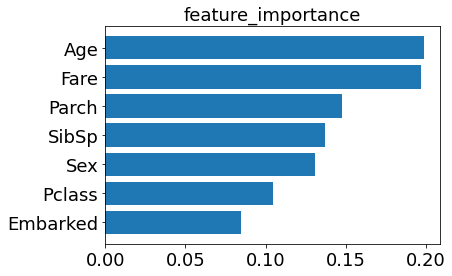

In [ ]:
for fold_num, model in enumerate(models):
    # Feature Importance
    feat_imp_fold = pd.DataFrame(model.feature_importances_,index=feature_col, columns= [f'imp_{fold_num}'])
    if fold_num == 0:
        feature_importance = feat_imp_fold.copy()
    else:
        feature_importance = pd.concat([feature_importance, feat_imp_fold], axis=1)
        
feature_importance['imp_mean'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values('imp_mean')

plt.tick_params(labelsize=18)
plt.barh(feature_importance.index.values,feature_importance['imp_mean']);
plt.title('feature_importance',fontsize=18);

## 12. Local explainability and masks

In [ ]:
explain_matrix, masks = model.explain(test[feature_col].values)

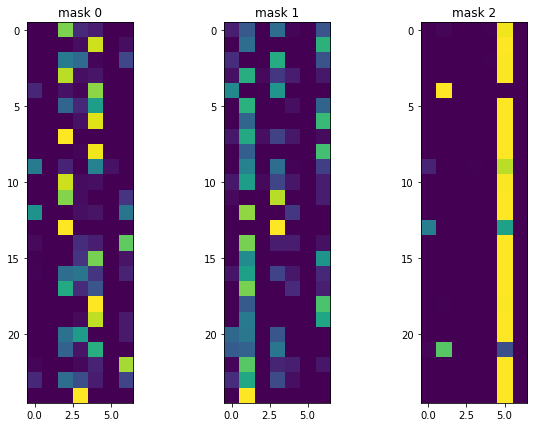

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,7))

for i in range(3):
    axs[i].imshow(masks[i][:25])
    axs[i].set_title(f"mask {i}")

In [ ]:
# 0 = 'Pclass', 1 = 'Sex', 2 = 'Age',3 =  'SibSp', 4 = 'Parch', 5 = 'Fare', 6 = 'Embarked'

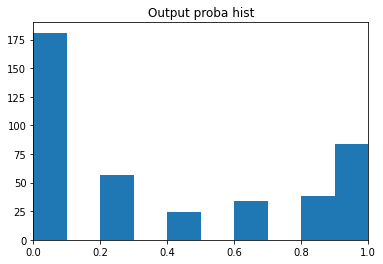

In [ ]:
plt.hist(test_preds_all);
plt.xlim(0.0,1.0)
plt.title('Output proba hist');

In [ ]:
sub['Survived'] = (test_preds_all > 0.5).astype('int')
sub.to_csv("submission.csv", index=False)

## 13. LightGBM

In [ ]:
# change to category
for col in categorical_columns:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
%%time
oof = np.zeros((len(train),))
test_preds_all = np.zeros((len(test),))
models = []

for fold_num in range(N_FOLDS):
    train_idx = train[train.fold != fold_num].index
    valid_idx = train[train.fold == fold_num].index

    print("FOLDS : ", fold_num)

    ## model
    X_train, y_train = train[feature_col].values[train_idx,], train['Survived'].values[train_idx,].astype(float)
    X_valid, y_valid = train[feature_col].values[valid_idx,], train['Survived'].values[valid_idx,].astype(float)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    params = {
        'objective': 'binary'
    }

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=10,
        num_boost_round=1000,
        early_stopping_rounds=10
    )
    
    # Calc Oof
    oof[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
    # Model
    models.append(model)

    # for save weight
    # name = f"fold{fold_num}"
    # model.save_model(name)    

    # preds on test
    test_preds_all += model.predict(test[feature_col], num_iteration=model.best_iteration) / N_FOLDS

FOLDS :  0
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.413407	valid_1's binary_logloss: 0.499251
[20]	training's binary_logloss: 0.342789	valid_1's binary_logloss: 0.466943
[30]	training's binary_logloss: 0.302868	valid_1's binary_logloss: 0.452358
[40]	training's binary_logloss: 0.272529	valid_1's binary_logloss: 0.452941
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.27758	valid_1's binary_logloss: 0.450995
FOLDS :  1
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.411839	valid_1's binary_logloss: 0.479499
[20]	training's binary_logloss: 0.333245	valid_1's binary_logloss: 0.464874
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.350684	valid_1's binary_logloss: 0.463001
FOLDS :  2
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.431464	valid_1's binary_logloss: 0.448133
[20]	training's binary_loglo

In [ ]:
print('ROC-AUC')
print(roc_auc_score(train['Survived'].ravel(), oof.ravel()))
print('Accuracy')
print(accuracy_score(train['Survived'].ravel(), (oof > 0.5).astype('int').ravel()))

ROC-AUC
0.8750306245273171
Accuracy
0.8260381593714927


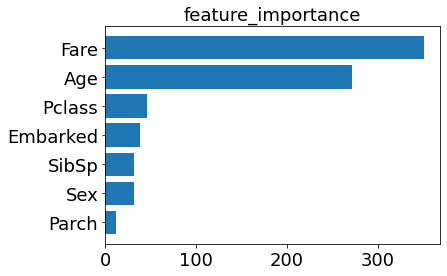

In [ ]:
# Feature Importance

for fold_num, model in enumerate(models):
    # Feature Importance
    feat_imp_fold = pd.DataFrame(model.feature_importance(), index=feature_col, columns= [f'imp_{fold_num}'])
    if fold_num == 0:
        feature_importance = feat_imp_fold.copy()
    else:
        feature_importance = pd.concat([feature_importance, feat_imp_fold], axis=1)
        
feature_importance['imp_mean'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values('imp_mean')

plt.tick_params(labelsize=18)
plt.barh(feature_importance.index.values,feature_importance['imp_mean']);
plt.title('feature_importance',fontsize=18);

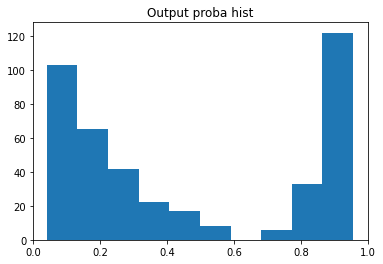

In [ ]:
plt.hist(test_preds_all);
plt.xlim(0.0,1.0)
plt.title('Output proba hist');

In [ ]:
# sub['Survived'] = (test_preds_all > 0.5).astype('int')
# sub.to_csv("submission.csv", index=False)

## 14. NN

In [ ]:
target_cols = ['Survived']

In [ ]:
class TitanicDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [ ]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [ ]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
NFOLDS = 5

BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = True

num_features=len(feature_col)
num_targets=1
hidden_size =150

In [ ]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.25)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.25)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.25)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [ ]:
def run_training(fold_num, seed, train, test, target_cols):
    
    seed_everything(seed)
    
    print("FOLDS : ", fold_num)
    
    train_idx = train[train.fold != fold_num].index
    valid_idx = train[train.fold == fold_num].index

    ## model
    X_train, y_train = train[feature_col].values[train_idx,], train[['Survived']].values[train_idx,].astype(float)
    X_valid, y_valid = train[feature_col].values[valid_idx,], train[['Survived']].values[valid_idx,].astype(float)
    
    train_dataset = TitanicDataset(X_train, y_train)
    valid_dataset = TitanicDataset(X_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)        
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                          max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(train), num_targets))
    predictions = np.zeros((len(test), num_targets))
    
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"seed{seed}, FOLD: {fold_num}, EPOCH: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            print('Update best loss')
            best_loss = valid_loss
            oof[valid_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold_num}_seed{seed}_.pth")
        
        elif(EARLY_STOP == True):
            early_step += 1
            if (early_step >= early_stopping_steps):
                print(f'Early Stop epoch{epoch} early_step{early_step}')
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test[feature_col].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )

    model.load_state_dict(torch.load(f"FOLD{fold_num}_seed{seed}_.pth"))
    model.to(DEVICE)

    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [ ]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))

    for fold_num in range(NFOLDS):
        oof_, pred_ = run_training(fold_num, seed, train, test, target_cols)

        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [ ]:
%%time
SEED = [33]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

print("######################## Training ############################")
for seed in SEED:
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

######################## Training ############################
FOLDS :  0
seed33, FOLD: 0, EPOCH: 0, train_loss: 0.7023162345091502, valid_loss: 0.6454835832118988
Update best loss
seed33, FOLD: 0, EPOCH: 1, train_loss: 0.529826154311498, valid_loss: 0.5778319835662842
Update best loss
seed33, FOLD: 0, EPOCH: 2, train_loss: 0.5730529725551605, valid_loss: 0.5215478986501694
Update best loss
seed33, FOLD: 0, EPOCH: 3, train_loss: 0.4841535836458206, valid_loss: 0.45016705989837646
Update best loss
seed33, FOLD: 0, EPOCH: 4, train_loss: 0.5152178953091303, valid_loss: 0.47253502905368805
seed33, FOLD: 0, EPOCH: 5, train_loss: 0.49520688752333325, valid_loss: 0.44771456718444824
Update best loss
seed33, FOLD: 0, EPOCH: 6, train_loss: 0.4765167087316513, valid_loss: 0.4593144804239273
seed33, FOLD: 0, EPOCH: 7, train_loss: 0.49099599321683246, valid_loss: 0.4489288181066513
seed33, FOLD: 0, EPOCH: 8, train_loss: 0.48385824263095856, valid_loss: 0.44169244170188904
Update best loss
seed33, 

In [ ]:
print('ROC-AUC')
print(roc_auc_score(train['Survived'].ravel(), oof.ravel()))
print('Accuracy')
print(accuracy_score(train['Survived'].ravel(), (oof > 0.5).astype('int').ravel()))

ROC-AUC
0.8643732890209738
Accuracy
0.8249158249158249


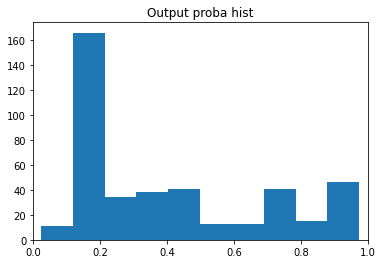

In [ ]:
plt.hist(predictions);
plt.xlim(0.0,1.0)
plt.title('Output proba hist');

In [ ]:
# sub['Survived'] = (predictions > 0.5).astype('int')
# sub.to_csv("submission.csv", index=False)